In [1]:
#%%
print('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting')

from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#%%
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting


In [2]:
def data_split(aa_array, encoded_mic):
    # Encode the target variable
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target
def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])
def data_prep_(cryptic, gene_list, dr_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']
    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']
    overlap = variants[~variants['sample_id'].isin(cryptic['ENA_RUN'])]
    overlap = overlap['sample_id'].unique()
    print(overlap)
    print(overlap.shape)
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']
    crypticSNPnames = np.load('crypticSNPnames.npy', allow_pickle=True)
    variants = variants[variants['SNP'].isin(crypticSNPnames)]
    # print(variants.shape)
    # print(variants['sample_id'].unique().shape)
    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        return output_list
    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data
    aa = []
    dr = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table
    for x in tqdm(overlap):
    # for x in tqdm(variants['sample_id'].unique()):
        if x in variants['sample_id'].tolist():
            aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
            if dr_list[0] in variants[variants['sample_id']==x]['drugs'].unique():
                dr.append(1)
            else:
                dr.append(0)
        else:
            # aa.append([0]*len(all_snp))
            pass
        # print('SNP')
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1
    # mic_aa = cryptic[cryptic['ENA_RUN'].isin(overlap)]#.iloc[:,14:27]
    # # mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # # print(mic_aa.shape)
    # # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # # mic_aa = mic_aa.sort_values('ENA_RUN')
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)
    # # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    # mic_aa = mic_aa.sort_values([“ENA_RUN”])  ## 'sort' changed to 'sort_values'
    # # print(mic_aa.shape)return aa_array, dr#, mic_aa
    return aa_array, dr

In [3]:
drs = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/all_sample_drs_cryptic_emb.npy')
snps = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/all_sample_snps_cryptic_emb.npy')

drs = pd.DataFrame(drs)     
train_data, test_data, train_target, test_target = data_split(snps, drs)

In [4]:
train_data.shape

(110469, 1473)

In [5]:
from torch.utils.data import Subset
from collections import Counter

N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)
#%%
def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_drugs]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        index = int(index)
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            mic = self.res_df.iloc[index, 0]
            # res = self.res_df.iloc[index, 1]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            mic = self.res_df.iloc[index, 0]
            # res = self.res_df.iloc[index, 1]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0),  torch.tensor(mic).long().flatten().squeeze()
    def __len__(self):
        return self.res_df.shape[0]

training_dataset = Dataset(train_data, train_target, one_hot_dtype=torch.float, transform=False)
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)

# train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

train_idx, validation_idx = train_test_split(np.arange(len(train_data)),
                                             test_size=0.1,
                                             random_state=42,
                                             shuffle=True,
                                             stratify=train_target)

# Subset dataset for train and val
train_dataset = Subset(training_dataset, train_idx)
val_dataset = Subset(training_dataset, validation_idx)

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # device = 'cpu'

y_true = train_target
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    # weights_inverse = 1 - frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map

def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn_mic = get_weighted_masked_cross_entropy_loss(column_weight_maps[0])
# weighted_cross_entropy_loss_fn_bi = get_weighted_masked_cross_entropy_loss(column_weight_maps['EMB_MIC_y'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss, optimizer, model):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f"#>> {appendix}, Epoch: {epoch}, LR: {lr}, fcDR: {fcdr}\n")
        f.write(f"Train_Loss= {train_loss}\n")
        f.write(f"Test_Loss= {test_loss}\n")
        f.write(f"lossGraph(Train_Loss, Test_Loss, '{appendix}-Epoch-{epoch}-LR-{lr}-fcDR-{fcdr}')\n")

    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

In [8]:
# Define the autoencoder class

class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 5000),
            nn.ReLU(),
            nn.Linear(5000, 2000),
            nn.ReLU(),
            nn.Linear(2000, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(100, 500),
            nn.ReLU(),
            nn.Linear(500, 2000),
            nn.ReLU(),
            nn.Linear(2000, 5000),
            nn.ReLU(),
            nn.Linear(5000, input_size),
            nn.Sigmoid()  # Use Sigmoid since input is binary
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# criterion = F.cross_entropy
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=8)

Epoch [10/100], Train Loss: 0.5070, Val Loss: 0.4944
Epoch [20/100], Train Loss: 0.5070, Val Loss: 0.4961
Epoch [30/100], Train Loss: 0.5070, Val Loss: 0.4909
Epoch [40/100], Train Loss: 0.5070, Val Loss: 0.4926
Epoch [50/100], Train Loss: 0.5070, Val Loss: 0.5118
Epoch [60/100], Train Loss: 0.5070, Val Loss: 0.4874
Epoch [70/100], Train Loss: 0.5070, Val Loss: 0.4996
Epoch [80/100], Train Loss: 0.5070, Val Loss: 0.4944
Epoch [90/100], Train Loss: 0.5070, Val Loss: 0.4891
Epoch [100/100], Train Loss: 0.5070, Val Loss: 0.4961


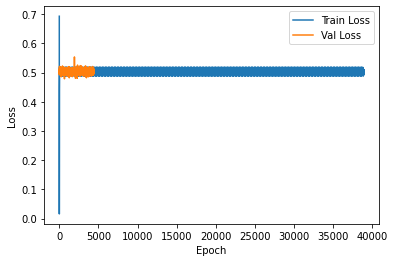

Training complete.


ValueError: Found array with dim 3. MLPClassifier expected <= 2.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.profiler

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=8)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
test_loader = DataLoader(dataset=testing_dataset, batch_size=batch_size, num_workers=8, shuffle=True)

for lr in [0.001]:

    # with torch.profiler.profile(
    #     activities=[
    #         torch.profiler.ProfilerActivity.CPU,
    #         torch.profiler.ProfilerActivity.CUDA,
    #     ],
    #     record_shapes=True,
    #     with_stack=True
    # ) as prof:
        # Parameters
    input_size = 1473  # Adjust this based on your input vector length
    num_epochs = 100

    # Instantiate the model, define loss function and optimizer
    model = Autoencoder(input_size).to(device)  # Move model to GPU
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss = []
    val_loss = []

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for data, _ in train_loader:
            # print('new batch', data.shape)
            data = data.to(device)  # Move data to GPU
            output = model(data)
            loss = criterion(output, data)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        
        # Validation phase
        model.eval()
        with torch.no_grad():  # Disable gradient computation during validation
            for data, _ in val_loader:
                data = data.to(device)  # Move data to GPU
                output = model(data)
                loss = criterion(output, data)
                val_loss.append(loss.item())
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}')

# prof.export_chrome_trace("torch_trace.json")

# Plot train loss and val loss

    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), 'autoencoder.pth')

    print('Training complete.')
    
    
    
    model.eval()

    compressed_data = []
    labels = []

    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)  # Move data to GPU
            compressed = model.encoder(data)
            compressed_data.append(compressed.cpu().numpy())
            labels.append(label.numpy())

    compressed_data = np.vstack(compressed_data)
    compressed_data = compressed_data.squeeze(axis=1)

    labels = np.hstack(labels)
    
        
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, accuracy_score
    from xgboost import XGBClassifier

    # Split the compressed data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(compressed_data, labels, test_size=0.2, random_state=42)

    # Initialize and train the MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)

    # Predict using the trained MLP
    y_pred = mlp.predict(X_test)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))
    
    # Initialize and train the XGBoost classifier
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)

    # Predict using the trained XGBoost model
    y_pred_xgb = xgb_model.predict(X_test)

    # Evaluate the performance
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
    print("\nXGBoost Classification Report:\n")
    print(classification_report(y_test, y_pred_xgb))
# %%javascript

# IPython.notebook.save_notebook()

In [21]:
f

NameError: name 'f' is not defined

In [22]:
  
    model.eval()

    compressed_data = []
    labels = []

    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)  # Move data to GPU
            compressed = model.encoder(data)
            compressed_data.append(compressed.cpu().numpy())
            labels.append(label.numpy())

    compressed_data = np.vstack(compressed_data)
    compressed_data = compressed_data.squeeze(axis=1)

    labels = np.hstack(labels)
    
        
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, accuracy_score
    from xgboost import XGBClassifier

    # Split the compressed data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(compressed_data, labels, test_size=0.2, random_state=42)

    # Initialize and train the MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)

    # Predict using the trained MLP
    y_pred = mlp.predict(X_test)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))
    
    # Initialize and train the XGBoost classifier
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)

    # Predict using the trained XGBoost model
    y_pred_xgb = xgb_model.predict(X_test)

    # Evaluate the performance
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
    print("\nXGBoost Classification Report:\n")
    print(classification_report(y_test, y_pred_xgb))

Accuracy: 73.48%

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1891
           1       0.24      0.07      0.11       564

    accuracy                           0.73      2455
   macro avg       0.51      0.50      0.48      2455
weighted avg       0.65      0.73      0.68      2455

XGBoost Accuracy: 96.82%

XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1891
           1       0.94      0.92      0.93       564

    accuracy                           0.97      2455
   macro avg       0.96      0.95      0.95      2455
weighted avg       0.97      0.97      0.97      2455



In [23]:
y_test.shape

(2455,)

In [20]:
# compressed_data = compressed_data.squeeze(axis=1)

labels = np.hstack(labels)

    
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Split the compressed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(compressed_data, labels, test_size=0.2, random_state=42)

# Initialize and train the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predict using the trained MLP
y_pred = mlp.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Initialize and train the XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predict using the trained XGBoost model
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the performan
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
print("\nXGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))
# %%javascript


Accuracy: 76.66%

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.99      0.87      1879
           1       0.55      0.03      0.06       576

    accuracy                           0.77      2455
   macro avg       0.66      0.51      0.46      2455
weighted avg       0.72      0.77      0.68      2455

XGBoost Accuracy: 97.27%

XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1879
           1       0.95      0.93      0.94       576

    accuracy                           0.97      2455
   macro avg       0.97      0.96      0.96      2455
weighted avg       0.97      0.97      0.97      2455



In [ ]:
torch.save(model.state_dict(), 'autonencoder_model_state.pth')


## Back up

In [2]:
def data_prep(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']

    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(variants['sample_id'].unique()):
        aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'

    return aa_array, mic_aa

def data_split(aa_array, encoded_mic):
    # Encode the target variable
    
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

def data_prep_(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']
    
    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

    overlap = variants[~variants['sample_id'].isin(cryptic['ENA_RUN'])]

    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']
    # print(variants.shape)
    # print(variants['sample_id'].unique().shape)

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(overlap):
    # for x in tqdm(variants['sample_id'].unique()):
        if x in variants['sample_id'].tolist():
            aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        else:
            aa.append([0]*len(all_snp))
            
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    # mic_aa = cryptic[cryptic['ENA_RUN'].isin(overlap)]#.iloc[:,14:27]
    # # mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # # print(mic_aa.shape)
    # # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # # mic_aa = mic_aa.sort_values('ENA_RUN')
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)
    # # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    # mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'
    # # print(mic_aa.shape)

    return aa_array#, mic_aa